# Heat equation - Retrieving operator by analytical formulation

In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint_adjoint as odeint
from heat import get_heat, get_heat_fd, get_heat_fe, get_heat_grad_t
from graphic_tools import simple_plotter, show_state
from initial_functions import gaussian_init, random_init, high_dim_random_init, heat_analytical_init

## Analytical solution

Compute the analytical solution u(t, x)

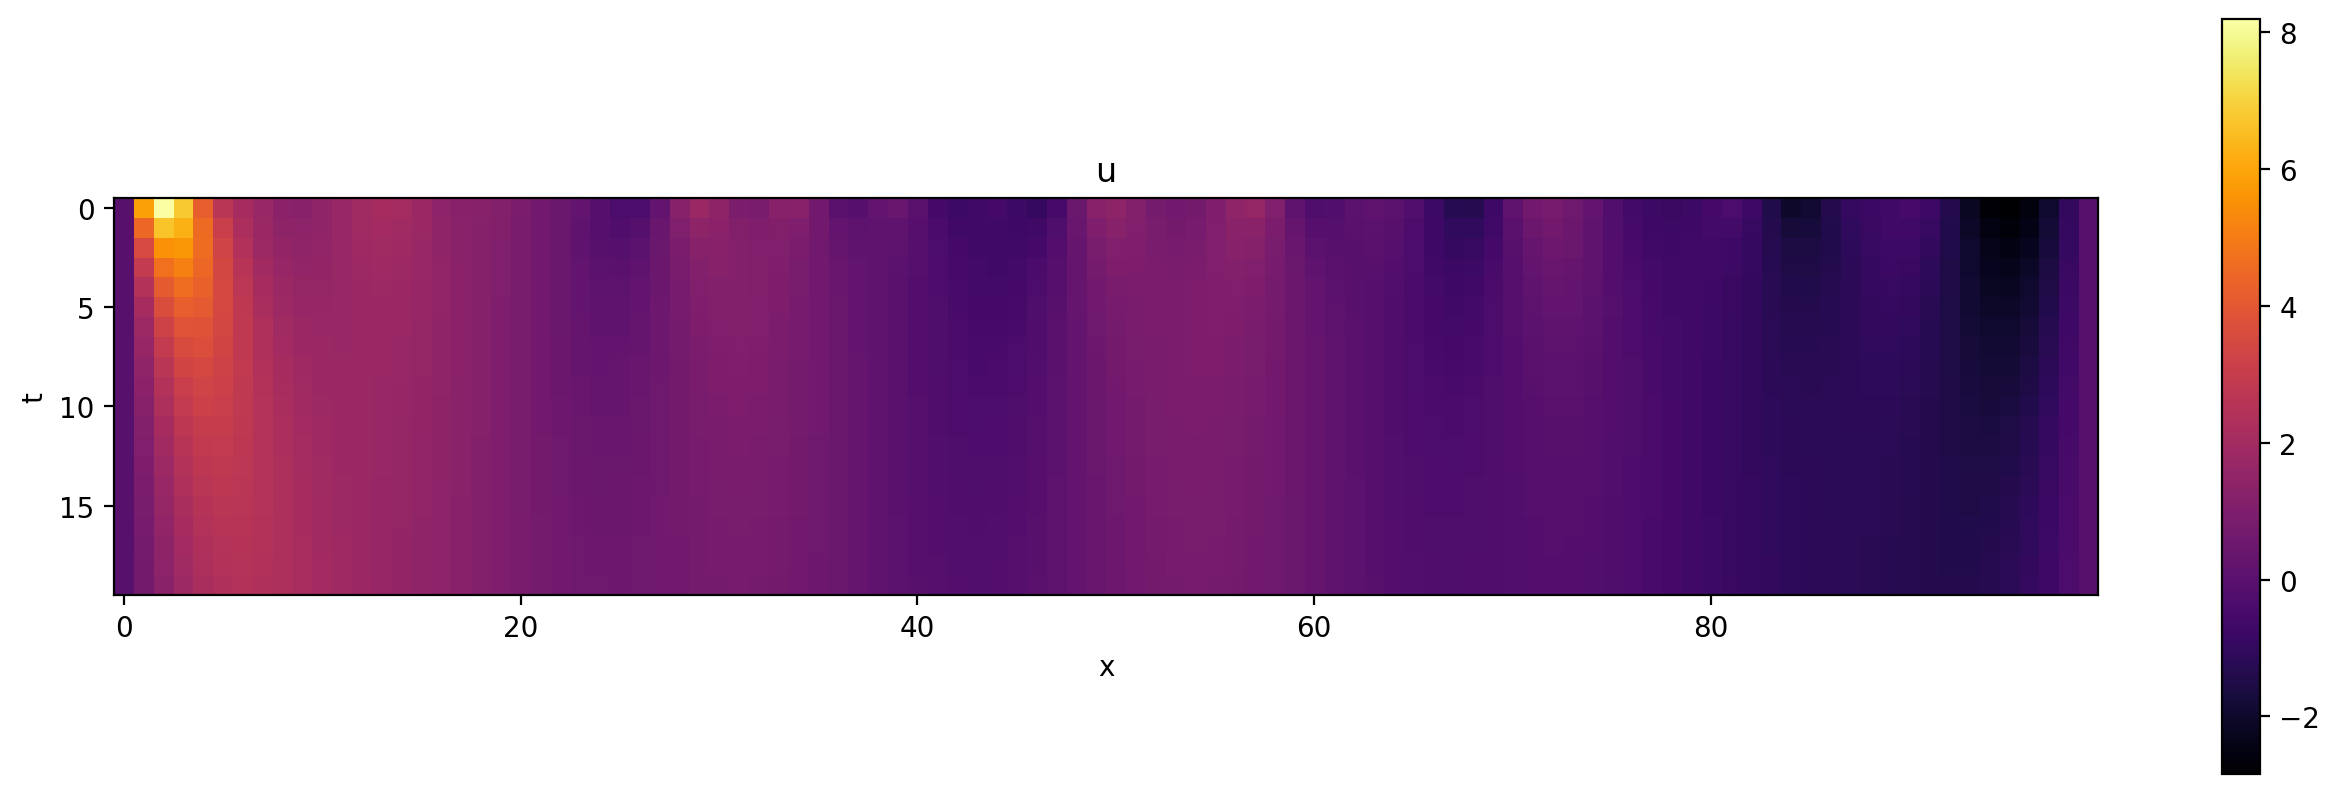

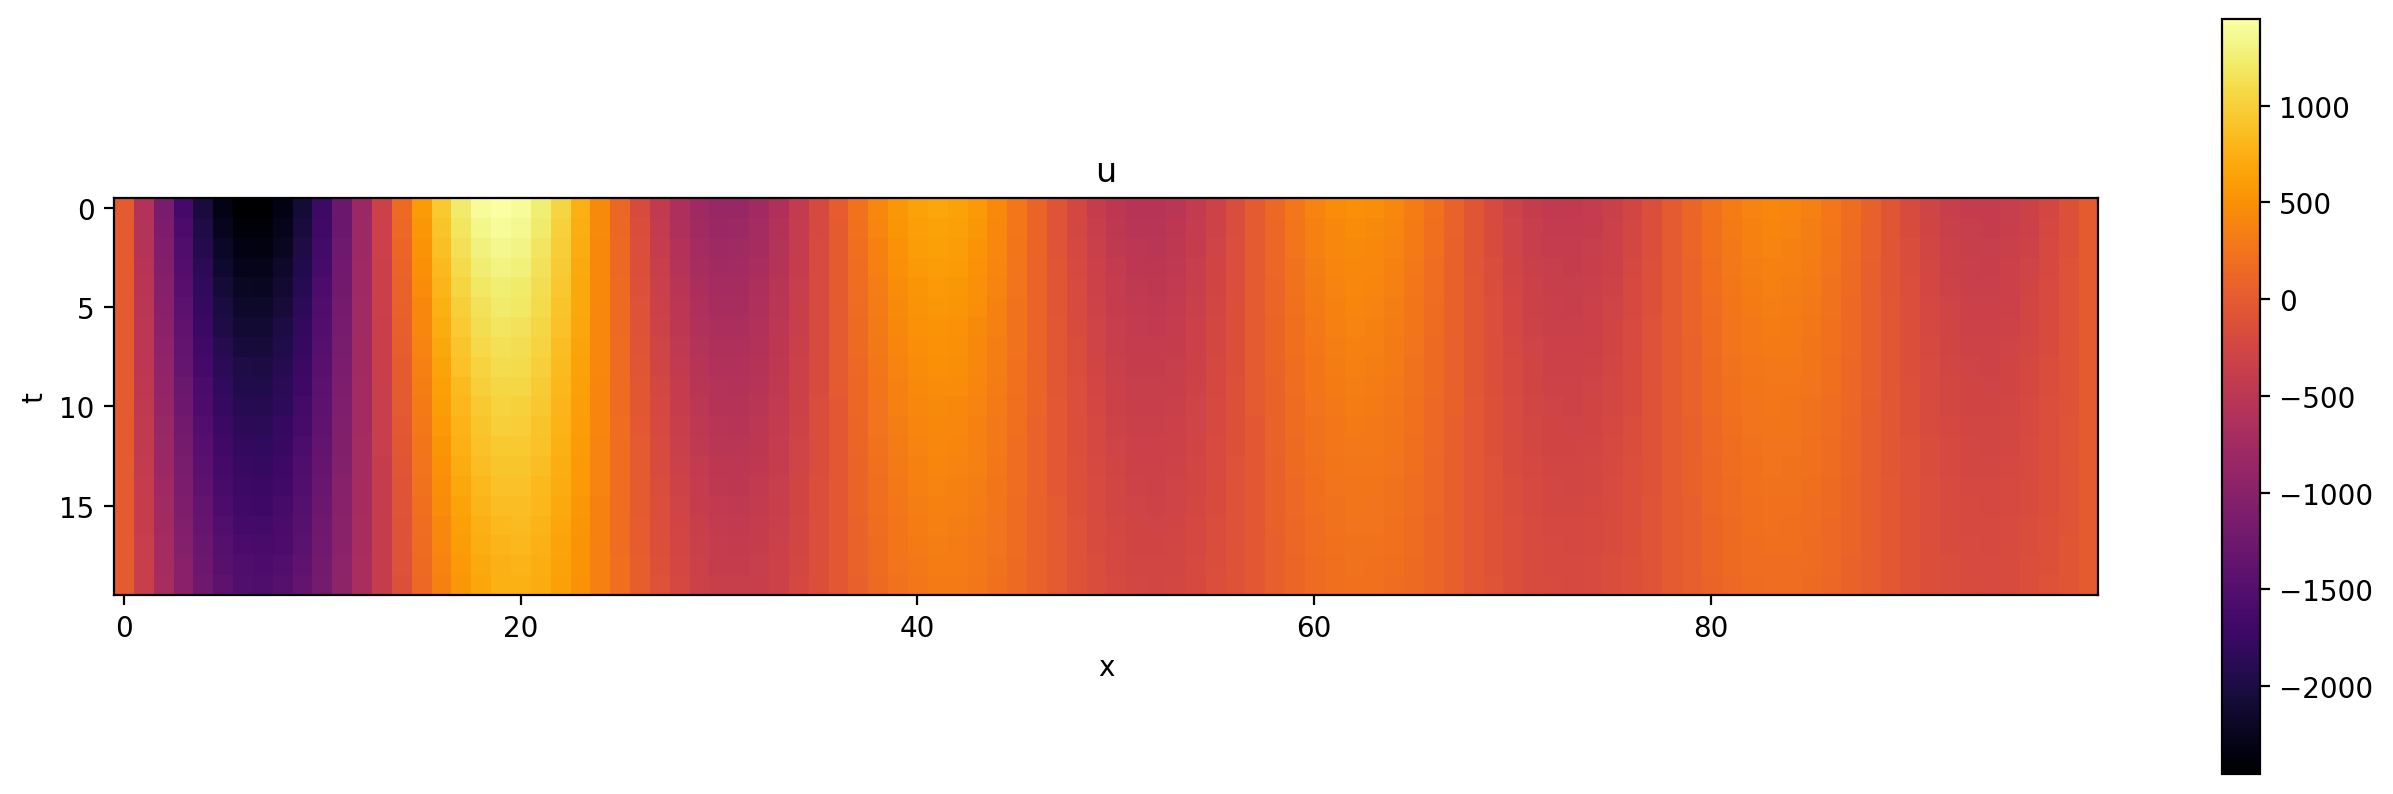

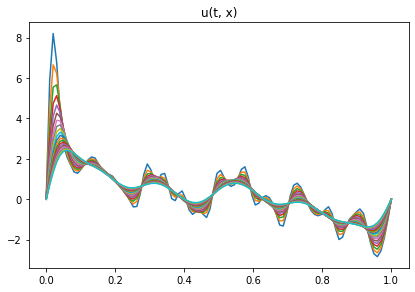

In [3]:
u_true, cn = get_heat(0.001, 0.0001, 1., 0., 20, 100, True)
g_u_true = get_heat_grad_t(0.001, 0.0001, 1., 0., 20, 100, cn)

show_state(u_true, 'u')
show_state(g_u_true, 'u')
simple_plotter(u_true, 'u(t, x)')

---

## Get operator F

Choice of parameters for the computations.

Small function to visualize the vector field expected for operator F.

In [ ]:
t_max, t_min = 0.2, 0.01
x_max, x_min = 1.0, 0.0

t_n = 100
x_n = 100

Considering the linear relation $Ax = b$, we can determine the operator F by setting $A = U$, $x = F$ and $b = U_t$. Thus, let's set:
$A x = b$

$F U = U_{t}$

$U^{T} F^{T} = U_{t}^{T}$

$U U^{T} F^{T} = U U_{t}^{T}$

$F^{T} = (U U^{T})^{-1} U U_{t}^{T}$

In [ ]:
def get_F(u, g_u):
    tmp = np.matmul(u, u.T)
    tmp2 = np.linalg.pinv(tmp)
    tmp3 = np.matmul(u, g_u.T)
    Ft = np.matmul(tmp2, tmp3)
    return Ft.T

In [ ]:
def get_ode_F(u, g_u):
    N = len(u)
    reg = 1e-8 * np.eye(N) # Avoid singular matrix
    F = np.linalg.solve(u @ u.T + reg, u @ g_u.T).T
    return F

In [ ]:
def get_true_F(X):
    dx = 1 / X
    F = np.zeros((X, X))
    for i in range(X):
        F[i, i] = -2
        
    for i in range(X - 1):
        F[i, i + 1] = 1
        F[i + 1, i] = 1
    
    return (1 / dx**2) * F

#### Analyze u obtains from operator F

In [ ]:
def analyze_error(F, u, g_u):
    return np.mean(np.abs(F @ u - g_u))

In [ ]:
def forward_euler(F, u, dt):
    return u + dt * F @ u

def solve(F, u0, t, dt=0.1, func=forward_euler):
    K = int(t / dt)
    u = np.copy(u0)

    for i in range(K):
        u = func(F, u, dt)
    return u

In [ ]:
u, cn = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, True) # (T, X)
g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn) # (T, X)

Ft = get_true_F(x_n)
F = get_F(u.T, g_u.T) # u.T = (X, T)
F2 = get_ode_F(u.T, g_u.T) # u.T = (X, T)

print("Error with true F : ", analyze_error(Ft, u.T, g_u.T))
print("Error with F : ", analyze_error(F, u.T, g_u.T))
print("Error with F2 : ", analyze_error(F2, u.T, g_u.T))

show_state(Ft, 'True F', '', '')
show_state(F2, 'F2', '', '')
show_state(F, 'F', '', '')

In [ ]:
print(np.mean(np.abs(Ft - F)))
print(np.mean(np.abs(Ft - F2)))
print(np.mean(np.abs(F - F2)))

Let's now introduction a simple Tikhonov regularization term. Our operator should now be computed as:

$F = (U U^{T} + \Gamma \Gamma^{T})^{-1}U U_{t}^{T}$

In [ ]:
def get_F_with_Tikhonov(u, g_u): # Basically the same regularization used in the ode case
    lb = 1e-8
    t_n = u.shape[0]
    tmp = np.matmul(u, u.T)
    tmp2 = lb * np.matmul(np.identity(t_n), np.identity(t_n).T) # regularization
    tmp3 = np.linalg.pinv(tmp + tmp2)
    tmp4 = np.matmul(u, g_u.T)
    F = np.matmul(tmp3, tmp4)
    return F

In [ ]:
u, cn = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, True)
g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn)
F_tik = get_F_with_Tikhonov(u.T, g_u.T)

In [ ]:
show_state(Ft, 'Ft')
show_state(F, 'F')
show_state(F2, 'F2')

In [ ]:
err_Ft_F = np.true_divide(np.abs(Ft - F), np.abs(Ft))
show_state(err_Ft_F, 'Relative error - F_true, F')

err_Ft_F2 = np.true_divide(np.abs(Ft - F2), np.abs(Ft))
show_state(err_Ft_F2, 'Relative error - F_true, F2')

err_F_F2 = np.true_divide(np.abs(F - F2), np.abs(F))
show_state(err_F_F2, 'Relative error - F, F2')

In [ ]:
show_state(g_u.T, 'du/dt', 'dudt', 'x')
show_state(F_tik @ u.T, 'F(u(x,t)) with tikhonov', 'Fu', 'x')
print(analyze_error(F_tik, u.T, g_u.T))

In [ ]:
print(np.mean(np.abs(Ft - F_tik)))
print(np.mean(np.abs(F_tik - F)))
print(np.mean(np.abs(F_tik - F2)))

--- 
## Reconstruction analysis

We want to go back to the fundamental of the forward operator F reconstruction.
Previously, we investigated 2 simple method to retrieve our operator F from a snapshot of the evolution u(t,x) through time. 
- One using an ODE solver with forward euler method to resolve $U^{T}F^{T} = U_t^{T}$. 
- An other one using analytical solution. 
However, these methods remains simple and we want to obtain an optimal forward operator F.

In a first time, we build our reference models.

In [41]:
t_n = 4096
x_n = 1024
x_min = 0.
x_max = 1.0
t_min = 0.00001
t_max = 0.001
t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

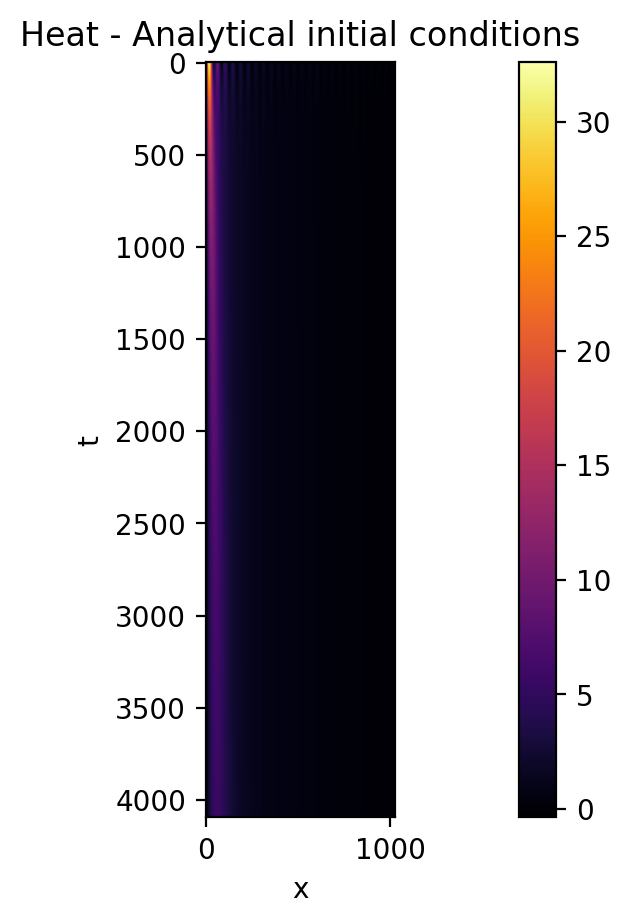

In [42]:
u0 = heat_analytical_init(t, x)
u_df, _ = get_heat_fd(t_max, t_min, x_max, x_min, t_n, x_n, u0)
show_state(u_df, 'Heat - Analytical initial conditions', 'x', 't', None)

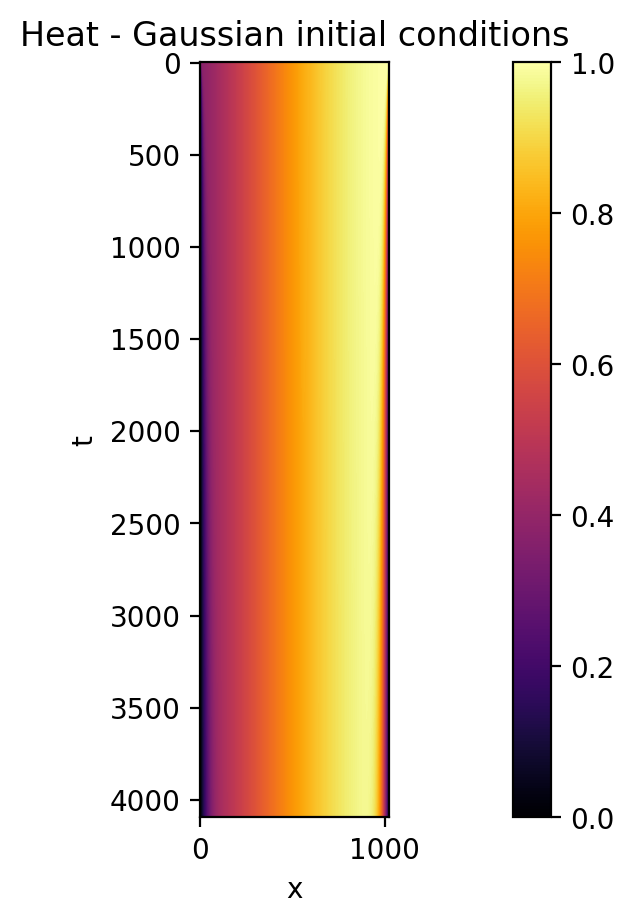

In [43]:
u0 = gaussian_init(t, x)
u_df, _ = get_heat_fd(t_max, t_min, x_max, x_min, t_n, x_n, u0)
show_state(u_df, 'Heat - Gaussian initial conditions', 'x', 't', None)

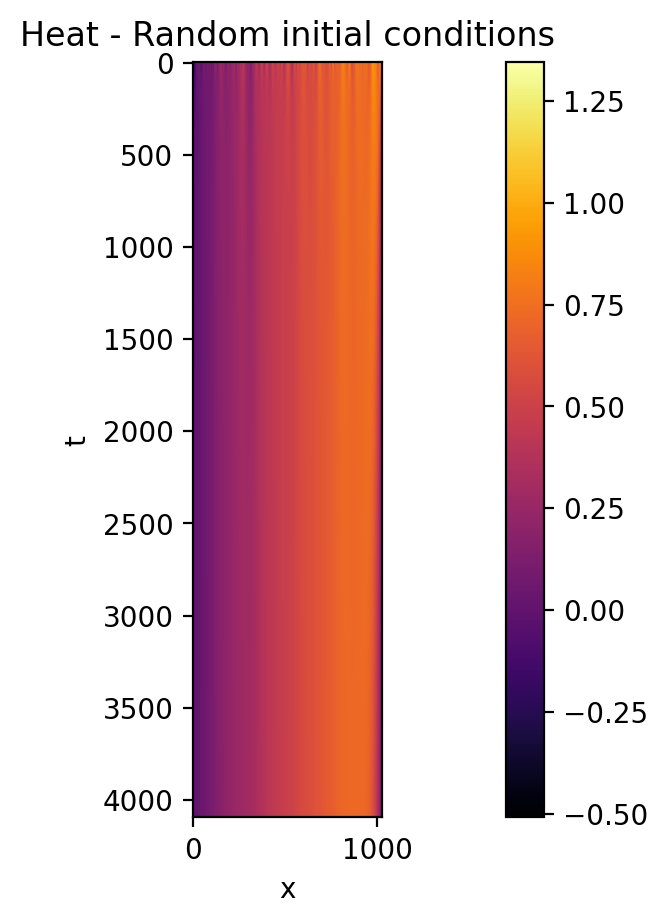

In [44]:
u0 = random_init(t, x)
u_df, _ = get_heat_fd(t_max, t_min, x_max, x_min, t_n, x_n, u0)
show_state(u_df, 'Heat - Random initial conditions', 'x', 't', None)

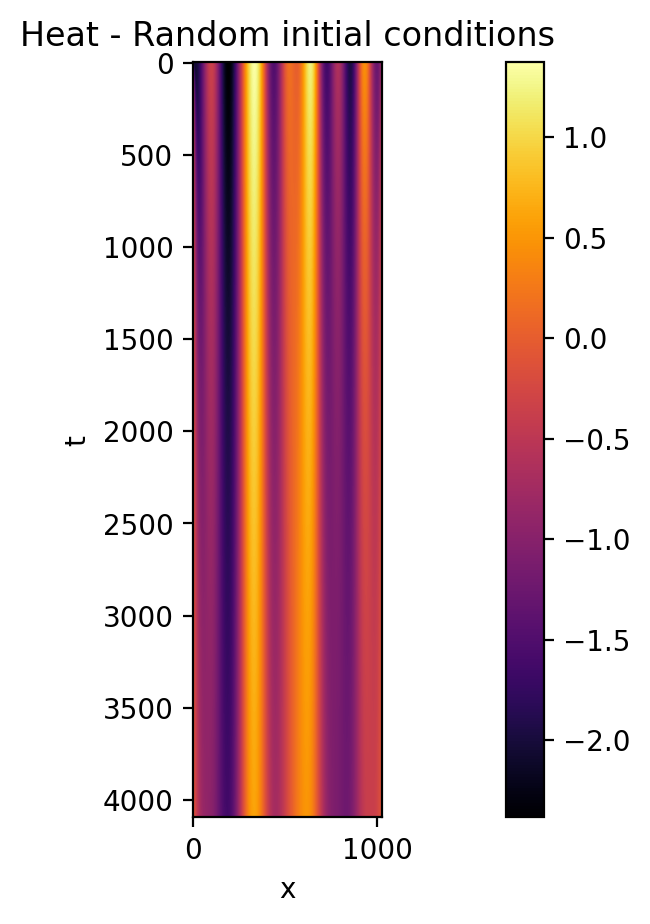

In [45]:
u0 = high_dim_random_init(t, x)
u_df, _ = get_heat_fd(t_max, t_min, x_max, x_min, t_n, x_n, u0)
show_state(u_df, 'Heat - Random initial conditions', 'x', 't', None)

---

### Reduce order model (ROM)

#### Basic downsampling

In [46]:
def downsampling(u, d=64):
    """
    @param u: snapshot
    @param d: interval of downsampling. Default 64
    """
    n, m = u.shape[0] // d, u.shape[1] // d
    d_u = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            d_u[i][j] = np.mean(u[i*d:(i+1)*d, j*d:(j+1)*d])
    
    return d_u

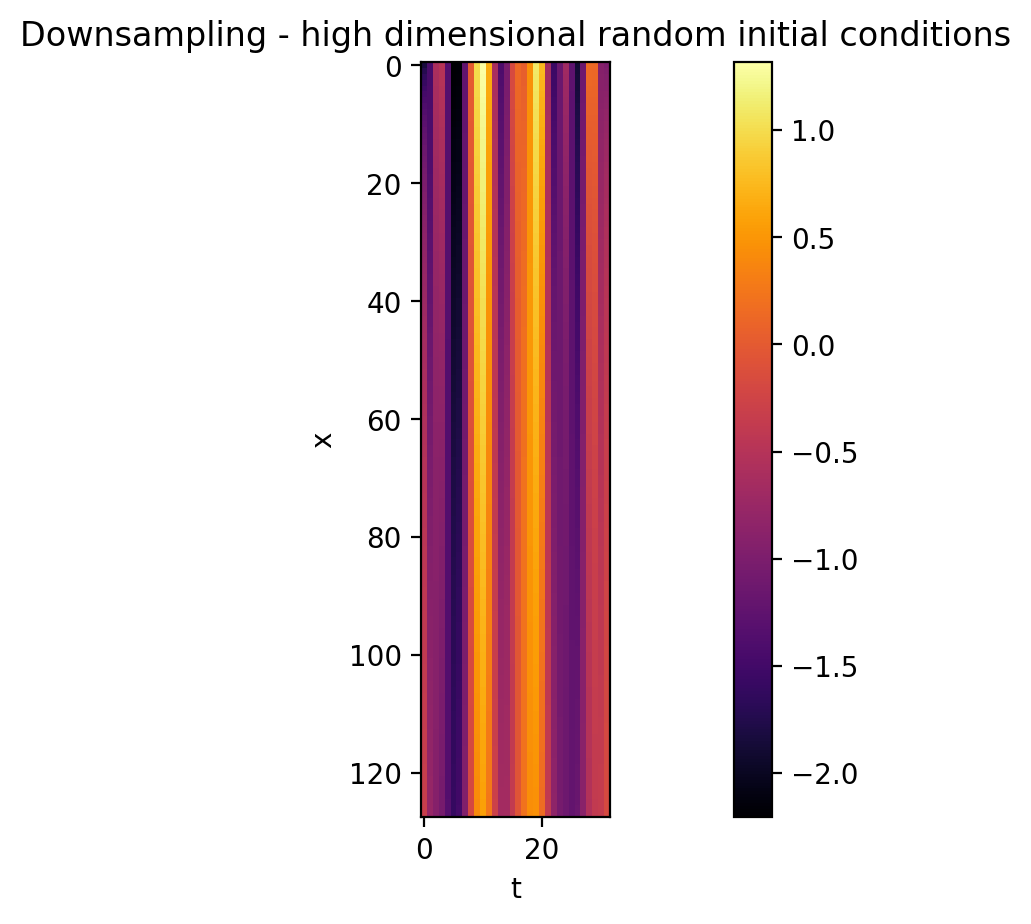

In [48]:
d_u = downsampling(u_df, 32)
show_state(d_u, 'Downsampling - high dimensional random initial conditions', 't', 'x', None)

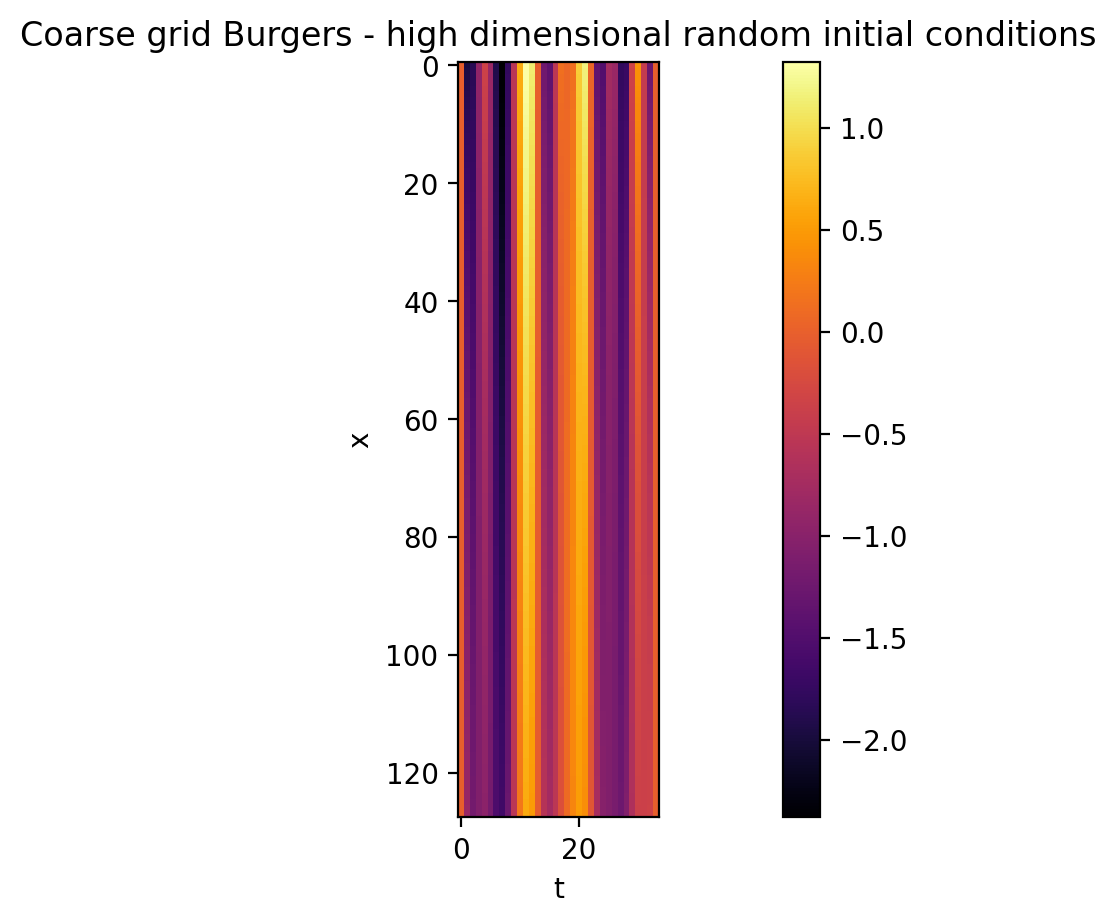

In [56]:
# todo - Implement other resolution method to handle instability
u02 = np.zeros((128, 34))
u02[:, 1:-1] = u0[::32, 1:-2:32]
coarse_u, _ = get_heat_fd(t_max, t_min, x_max, x_min, 128, 32, u02)
show_state(coarse_u, 'Coarse grid Burgers - high dimensional random initial conditions', 't', 'x', None)